## Import useful libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

seed = 42

## Load the data and visualize it

In [3]:
data = pd.read_csv('train.csv')
data_test = pd.read_csv('test.csv')

In [6]:
data.head()

,id,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title,price
0,0,MINI,Cooper S Base,2007,213000,Gasoline,172.0HP 1.6L 4 Cylinder Engine Gasoline Fuel,A/T,Yellow,Gray,None reported,Yes,4200
1,1,Lincoln,LS V8,2002,143250,Gasoline,252.0HP 3.9L 8 Cylinder Engine Gasoline Fuel,A/T,Silver,Beige,At least 1 accident or damage reported,Yes,4999
2,2,Chevrolet,Silverado 2500 LT,2002,136731,E85 Flex Fuel,320.0HP 5.3L 8 Cylinder Engine Flex Fuel Capab...,A/T,Blue,Gray,None reported,Yes,13900
3,3,Genesis,G90 5.0 Ultimate,2017,19500,Gasoline,420.0HP 5.0L 8 Cylinder Engine Gasoline Fuel,Transmission w/Dual Shift Mode,Black,Black,None reported,Yes,45000
4,4,Mercedes-Benz,Metris Base,2021,7388,Gasoline,208.0HP 2.0L 4 Cylinder Engine Gasoline Fuel,7-Speed A/T,Black,Beige,None reported,Yes,97500


In [9]:
print(f"Training set: \t{data.shape[0]} rows \t{data.shape[1]} columns")
print(f"Test set: \t{data_test.shape[0]} rows \t{data_test.shape[1]} columns")

Training set: 	188533 rows 	13 columns
Test set: 	125690 rows 	12 columns


In [14]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 188533 entries, 0 to 188532
Data columns (total 13 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            188533 non-null  int64 
 1   brand         188533 non-null  object
 2   model         188533 non-null  object
 3   model_year    188533 non-null  int64 
 4   milage        188533 non-null  int64 
 5   fuel_type     183450 non-null  object
 6   engine        188533 non-null  object
 7   transmission  188533 non-null  object
 8   ext_col       188533 non-null  object
 9   int_col       188533 non-null  object
 10  accident      186081 non-null  object
 11  clean_title   167114 non-null  object
 12  price         188533 non-null  int64 
dtypes: int64(4), object(9)
memory usage: 18.7+ MB


In [16]:
data.describe(include='object')

,brand,model,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title
count,188533,188533,183450,188533,188533,188533,188533,186081,167114
unique,57,1897,7,1117,52,319,156,2,1
top,Ford,F-150 XLT,Gasoline,355.0HP 5.3L 8 Cylinder Engine Gasoline Fuel,A/T,Black,Black,None reported,Yes
freq,23088,2945,165940,3462,49904,48658,107674,144514,167114


In [18]:
data.isnull().sum()

id                  0
brand               0
model               0
model_year          0
milage              0
fuel_type        5083
engine              0
transmission        0
ext_col             0
int_col             0
accident         2452
clean_title     21419
price               0
dtype: int64

In [19]:
data_test.isnull().sum()

id                  0
brand               0
model               0
model_year          0
milage              0
fuel_type        3383
engine              0
transmission        0
ext_col             0
int_col             0
accident         1632
clean_title     14239
dtype: int64

In [20]:
data['brand'].value_counts()

brand
Ford             23088
Mercedes-Benz    19172
BMW              17028
Chevrolet        16335
Audi             10887
Porsche          10612
Land              9525
Toyota            8850
Lexus             8643
Jeep              6474
Cadillac          4674
RAM               4249
Nissan            3930
Tesla             3738
INFINITI          3276
GMC               3215
Dodge             3133
Mazda             2719
Kia               2497
Lincoln           2423
Subaru            2381
Acura             2282
Honda             2101
Hyundai           2045
Volkswagen        1765
Jaguar            1319
Bentley           1155
MINI              1064
Genesis            969
Buick              940
Maserati           939
Lamborghini        809
Chrysler           727
Volvo              723
Alfa               682
Rivian             590
Rolls-Royce        561
Mitsubishi         551
Pontiac            538
Hummer             520
Ferrari            359
McLaren            243
Aston              238
Satur

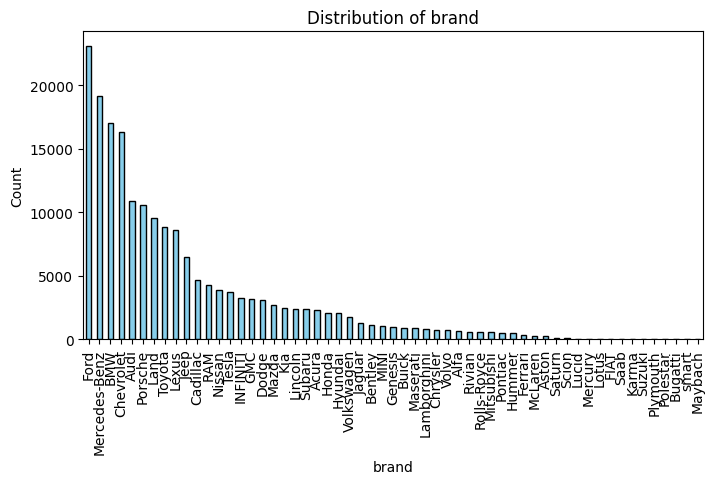

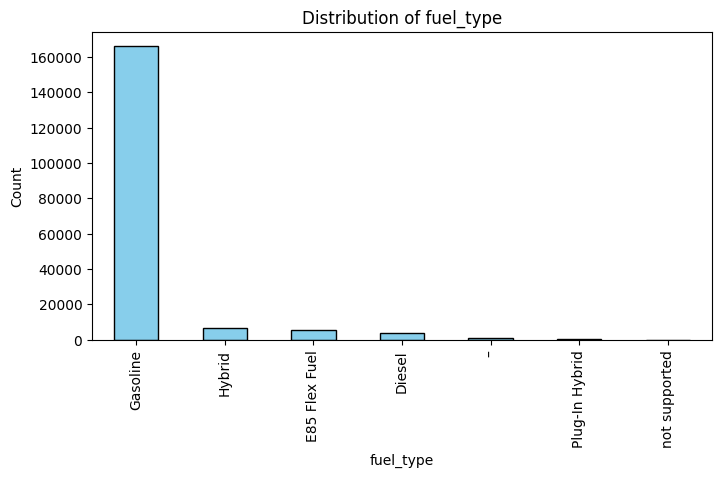

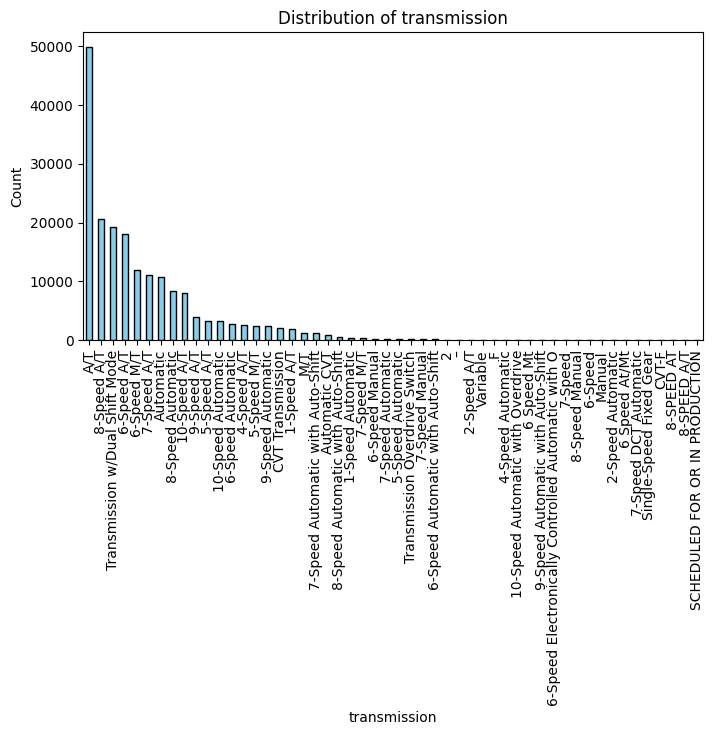

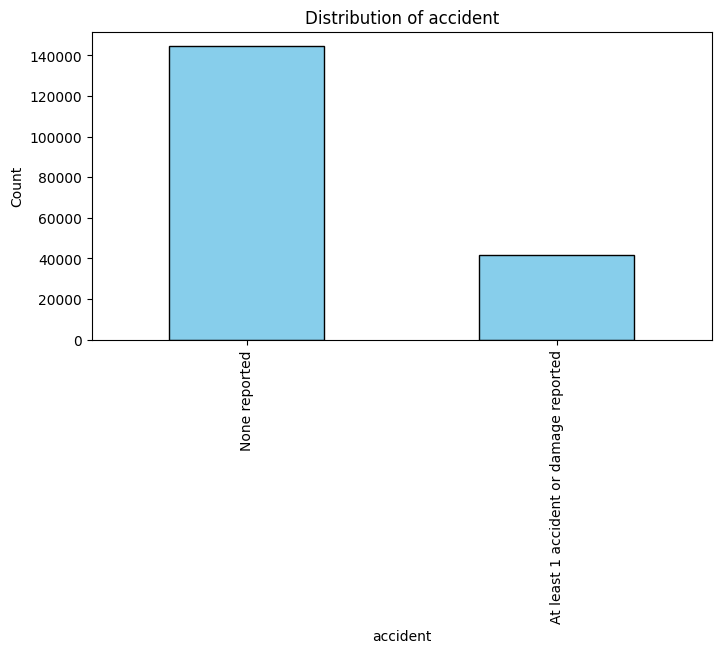

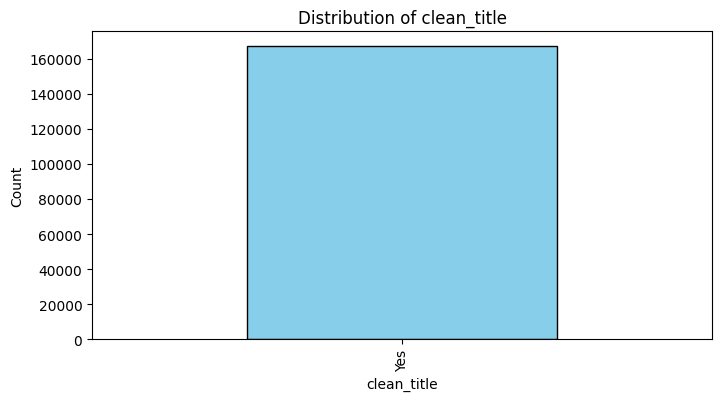

In [21]:
categorical_columns = ['brand', 'fuel_type', 'transmission', 'accident', 'clean_title']

for col in categorical_columns:
    plt.figure(figsize=(8, 4))
    data[col].value_counts().plot(kind='bar', color='skyblue', edgecolor='black')
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Count')
    plt.show()

## Work on features

In [23]:
data['fuel_type'] = data['fuel_type'].replace(['-', 'not supported', np.nan], 'Unknown')
data_test['fuel_type'] = data_test['fuel_type'].replace(['-', 'not supported', np.nan], 'Unknown')